In [97]:
# Importer les bibliothèques nécessaires
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

In [26]:
# Lire les données depuis le fichier CSV
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [14]:
# Voir les premières lignes du dataset
data.head(60)

NameError: name 'data' is not defined

### COMPREHENSION DES DONNEES

##### Lien: https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [28]:
# Avoir une vue d'ensemble des données
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Nous remarquons 21 variables dans ce dataset, 7043 Champs donc lignes, pas de valeurs manquantes, une valeur numérique décimale, 2 valeurs numériques entières, et 18 valeurs textuelles ou chaînes de caractères. 

In [29]:
# Se rassurer du nombre de lignes et de colonnes
data.shape

(7043, 21)

7043 lignes et 21 colonnes.

In [30]:
# Vérifier la présence de valeurs dupliquées
data.duplicated().sum()

np.int64(0)

Aucune valeur dupppliquée.

## ANALYSE DESCRIPTIVE

### ANALYSE UNIVARIEE

Cette analyse nous permettra de comprendre individuellement les données grâce à des résumés statistiques.

#### Examen de la variable à prédire(Target)

In [31]:
# Voir les valeurs uniques de la variable cible 'Churn'
data['Churn'].unique()

array(['No', 'Yes'], dtype=object)

La variable cible "Churn" nous montre deux valeurs uniques qui sont:"No" et "Yes". Cette information nous 
permet de définir à quel problème de Machine Learning nous sommes confrontés.

Nous savons déjà que notre objectif est de prédire une variable cible donc résolvons un problème de Machine Learning supervisé, et la variable cible qui nous présente seulement deux valeurs nous fait comprendre plus profondément que nous résolvons un problème de: Machine Learning Supervisé de type classification binaire(2 valeurs).

NB: On peut avoir un problème de classification plus que binaire, nous devons seulement remarquer si la liste de valeurs de notre variable trouve des limites. Généralement si la liste de nos variables dépasse 9 valeurs, nous ne sommes plus dans un problème de classification.

"Churn" est une variable catégorielle, elle définit les catégories: "Churné" et "Non-churné".

#### Distribution des variables

##### Distribution de la target

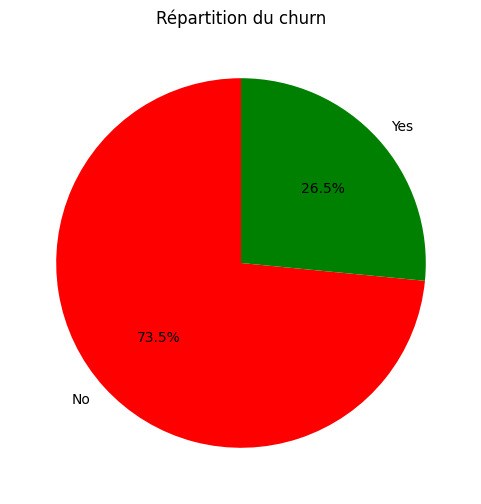

In [32]:
# Compter les valeurs de la target
churn_counts = data["Churn"].value_counts()

# Diagramme circulaire
plt.figure(figsize=(6,6))
plt.pie(
    churn_counts,
    labels=churn_counts.index,
    autopct="%1.1f%%",   # pour afficher les pourcentages
    startangle=90,       # pour démarrer à 90°
    colors=["red", "green"]  # couleurs personnalisées
)
plt.title("Répartition du churn")
plt.show()

On remarque qu'il y a un grand désiquilibre entre les personnes qui ont churné et ceux qui ne l'ont pas fait.

Et cette information est une preuve que l'on doit traiter cette variable et la rééquilibrer pour que la prédiction soit sans partialité.

#### Distribution des variables continues 

Identifions les variables continues. Ces variables sont: tenure, MonthlyCharges, TotalCharges.

In [34]:
# Vérifier les types de données de ces colonnes
print(data[["tenure", "MonthlyCharges", "TotalCharges"]].dtypes)

tenure              int64
MonthlyCharges    float64
TotalCharges       object
dtype: object


"TotalCharges" étant de type chaine de caractère, on doit lui donner son vrai type qui est de valeur décimale.

In [36]:
# Convertir la colonne "TotalCharges" en type numérique
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

In [37]:
# Vérifier à nouveau les types de données de ces colonnes
print(data[["tenure", "MonthlyCharges", "TotalCharges"]].dtypes)

tenure              int64
MonthlyCharges    float64
TotalCharges      float64
dtype: object


Nous remarquons que "TotalCharges" est devenu valeur décimale.

In [38]:
# Statistiques descriptives uniquement pour ces variables continues
data[["tenure", "MonthlyCharges", "TotalCharges"]].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


En voyant ce tableau qui résume statistiquement nos 3 variables on peut constater que:

* "Tenure" est légèrement asymétrique à droite il se laisse influencer par sa valeur maximale car sa moyenne est légèrement au dessus de sa médiane.
* "MonthlyCharges" est asymétrique à gauche il se laisse influencer par sa valeur minimale car sa moyenne est se situe bien en dessous de sa médiane.
* "TotalCharges" est asymétrique à droite il se laisse fortement influencer par sa valeur maximale car sa moyenne est se situe grandement au dessus de sa médiane.

Donc, nous comprenons que nos 3 variables des distributions asymétriques influencées par la logique métier, ce qui n'est agréable pour notre modèle.

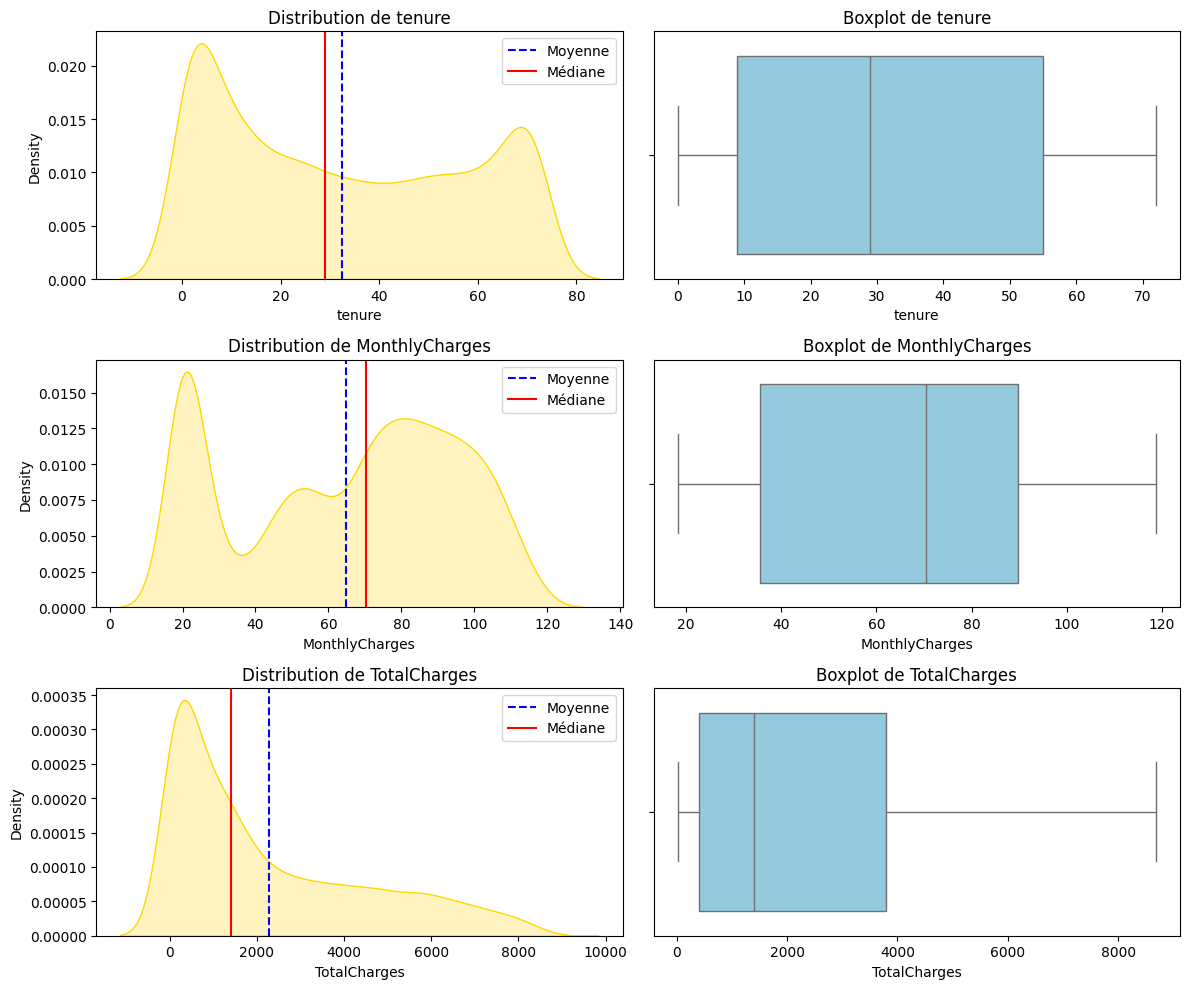

In [59]:
# Courbes de densité (KDE) et boxplots pour chaque variable continue
data_var_continues = ["tenure", "MonthlyCharges", "TotalCharges"]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, col in enumerate(data_var_continues):
    mean_val = data[col].mean()
    median_val = data[col].median()
    
    # KDE avec moyenne et médiane
    sns.kdeplot(data[col], color='gold', fill=True, ax=axes[i,0])
    axes[i,0].axvline(mean_val, color="blue", linestyle="--", linewidth=1.5, label="Moyenne")
    axes[i,0].axvline(median_val, color="red", linestyle="-", linewidth=1.5, label="Médiane")
    axes[i,0].set_title(f"Distribution de {col}")
    axes[i,0].legend()
    
    # Boxplot
    sns.boxplot(x=data[col], color="skyblue", ax=axes[i,1])
    axes[i,1].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()


In [60]:
# Confirmer l'asymétrie avec les coefficients de skewness et kurtosis
pd.DataFrame(
    {
        "skewness": data[["tenure", "MonthlyCharges", "TotalCharges"]].skew(),
        "kurtosis": data[["tenure", "MonthlyCharges", "TotalCharges"]].kurtosis()
    }
)

,skewness,kurtosis
tenure,0.239540,-1.387372
MonthlyCharges,-0.220524,-1.257260
TotalCharges,0.961642,-0.231799


#### Distribution des variables categorielles

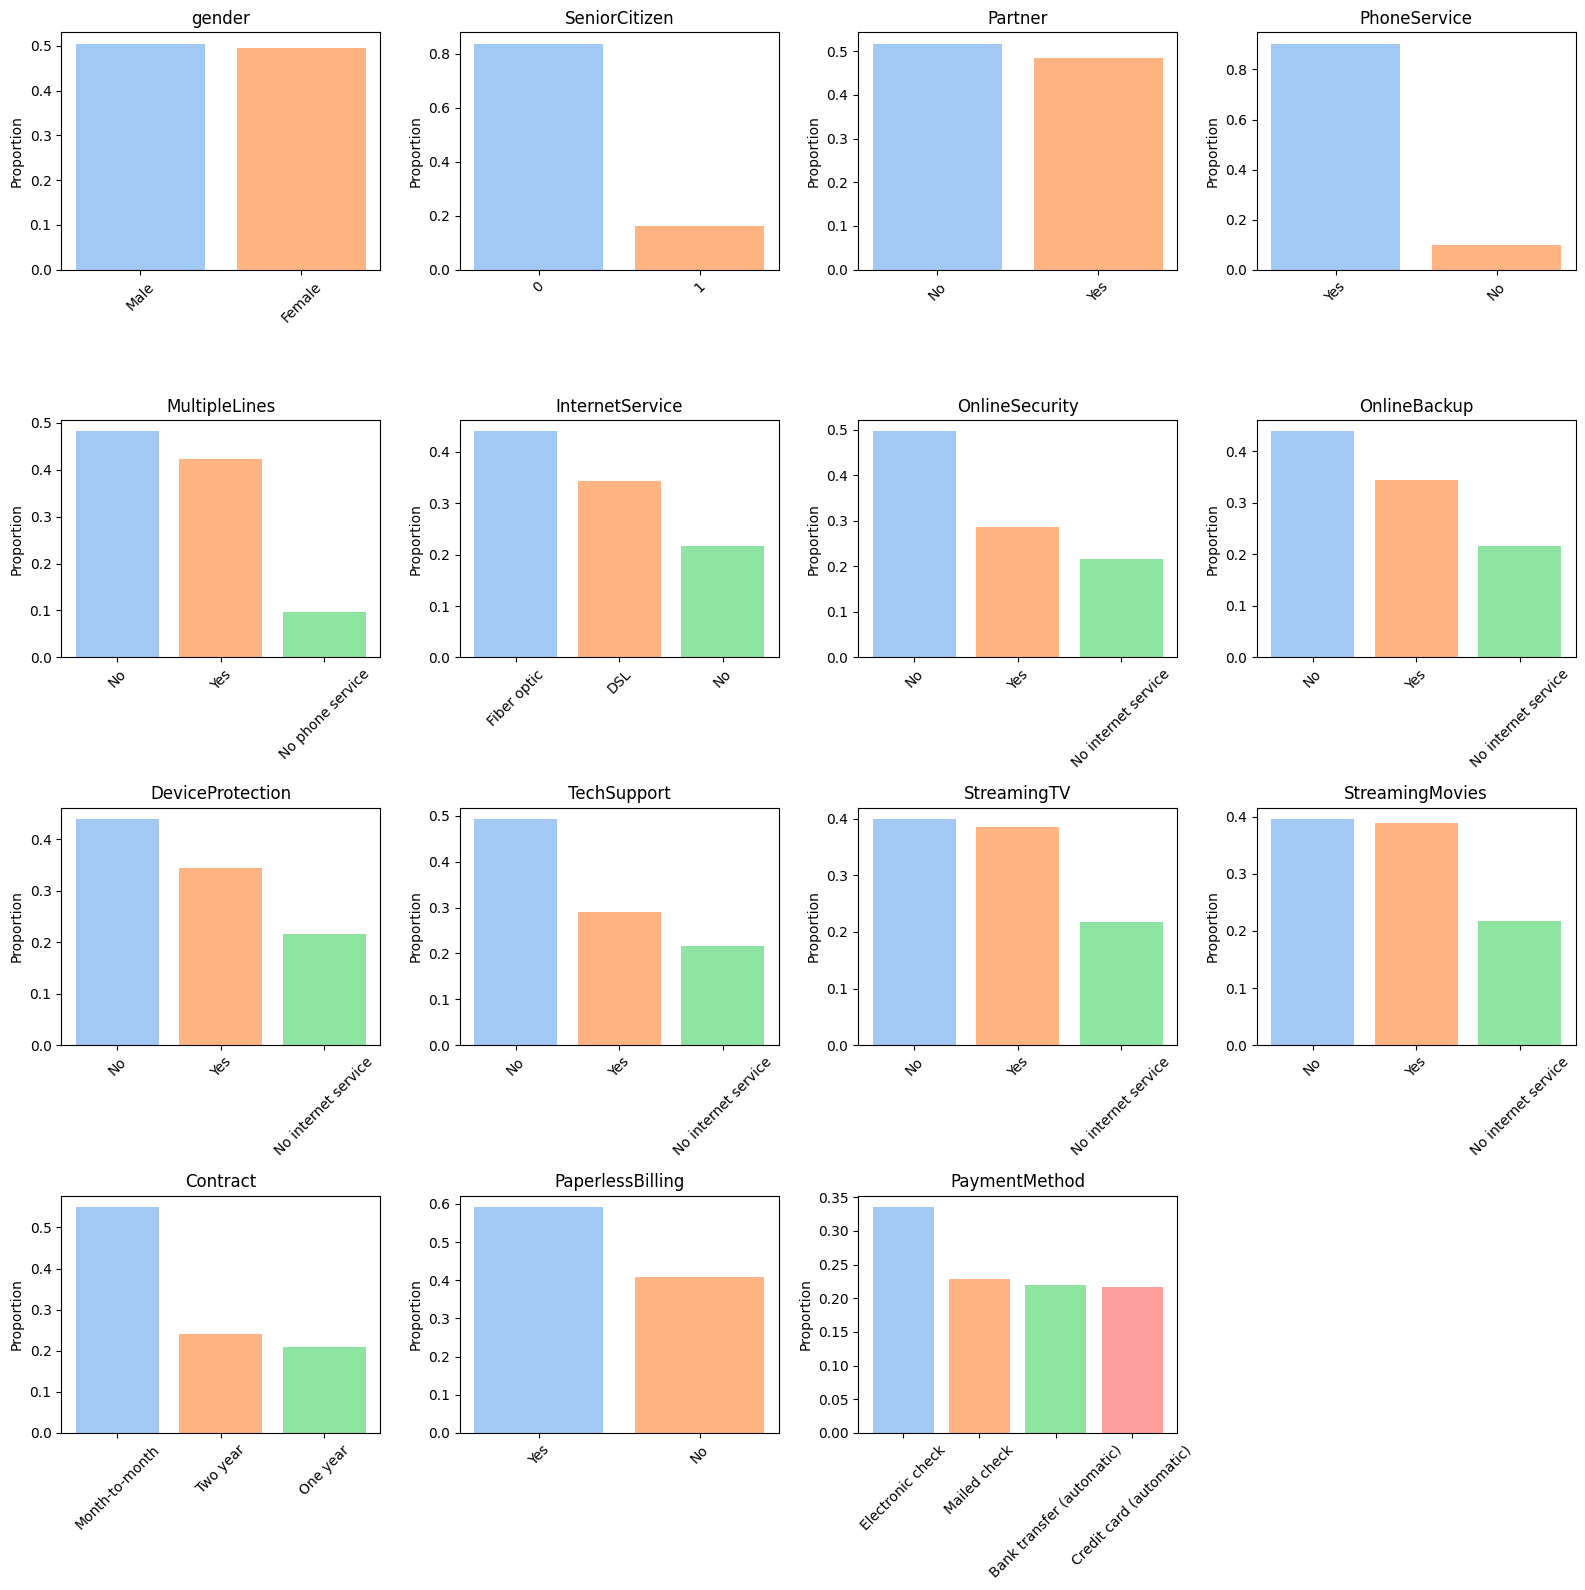

In [76]:
# Variables catégorielles
data_cat = ["gender","SeniorCitizen","Partner","PhoneService","MultipleLines", 
            "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
            "TechSupport", "StreamingTV", "StreamingMovies","Contract",
            "PaperlessBilling", "PaymentMethod"]

# Définir la grille : 4 lignes, colonnes calculées automatiquement
n_rows = 4
n_cols = math.ceil(len(data_cat) / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

# Palette pastel globale pour toutes les barres
global_palette = sns.color_palette("pastel", 10)  # 10 couleurs pour toutes les catégories possibles

for i, col in enumerate(data_cat):
    counts = data[col].value_counts(normalize=True)
    colors = global_palette[:len(counts)]  # choisir autant de couleurs que de catégories
    
    # tracer les barres une par une pour éviter les warnings
    for j, (val, color) in enumerate(zip(counts.values, colors)):
        axes[i].bar(j, val, color=color)
    
    axes[i].set_title(col, fontsize=12)
    axes[i].set_ylabel("Proportion")
    axes[i].set_xticks(range(len(counts)))
    axes[i].set_xticklabels(counts.index, rotation=45)
    axes[i].set_xlabel("")

# Supprimer les axes vides s'il y en a
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


On peut remarquer une distribution générale désiquilibrée, ce qui n'est approprié pour construire notre modèle.

### ANALYSE BIVARIEE

Cette analyse a pour but de comprendre les relations qui existent entre deux variables notamment la relation entre variables explicatives(features) et la variable expliquée(target). Et voire même relation existant entre deux variables explicatives.

#### Relation entre variable explicative et variable cible

Variables Catégorielles et variable cible

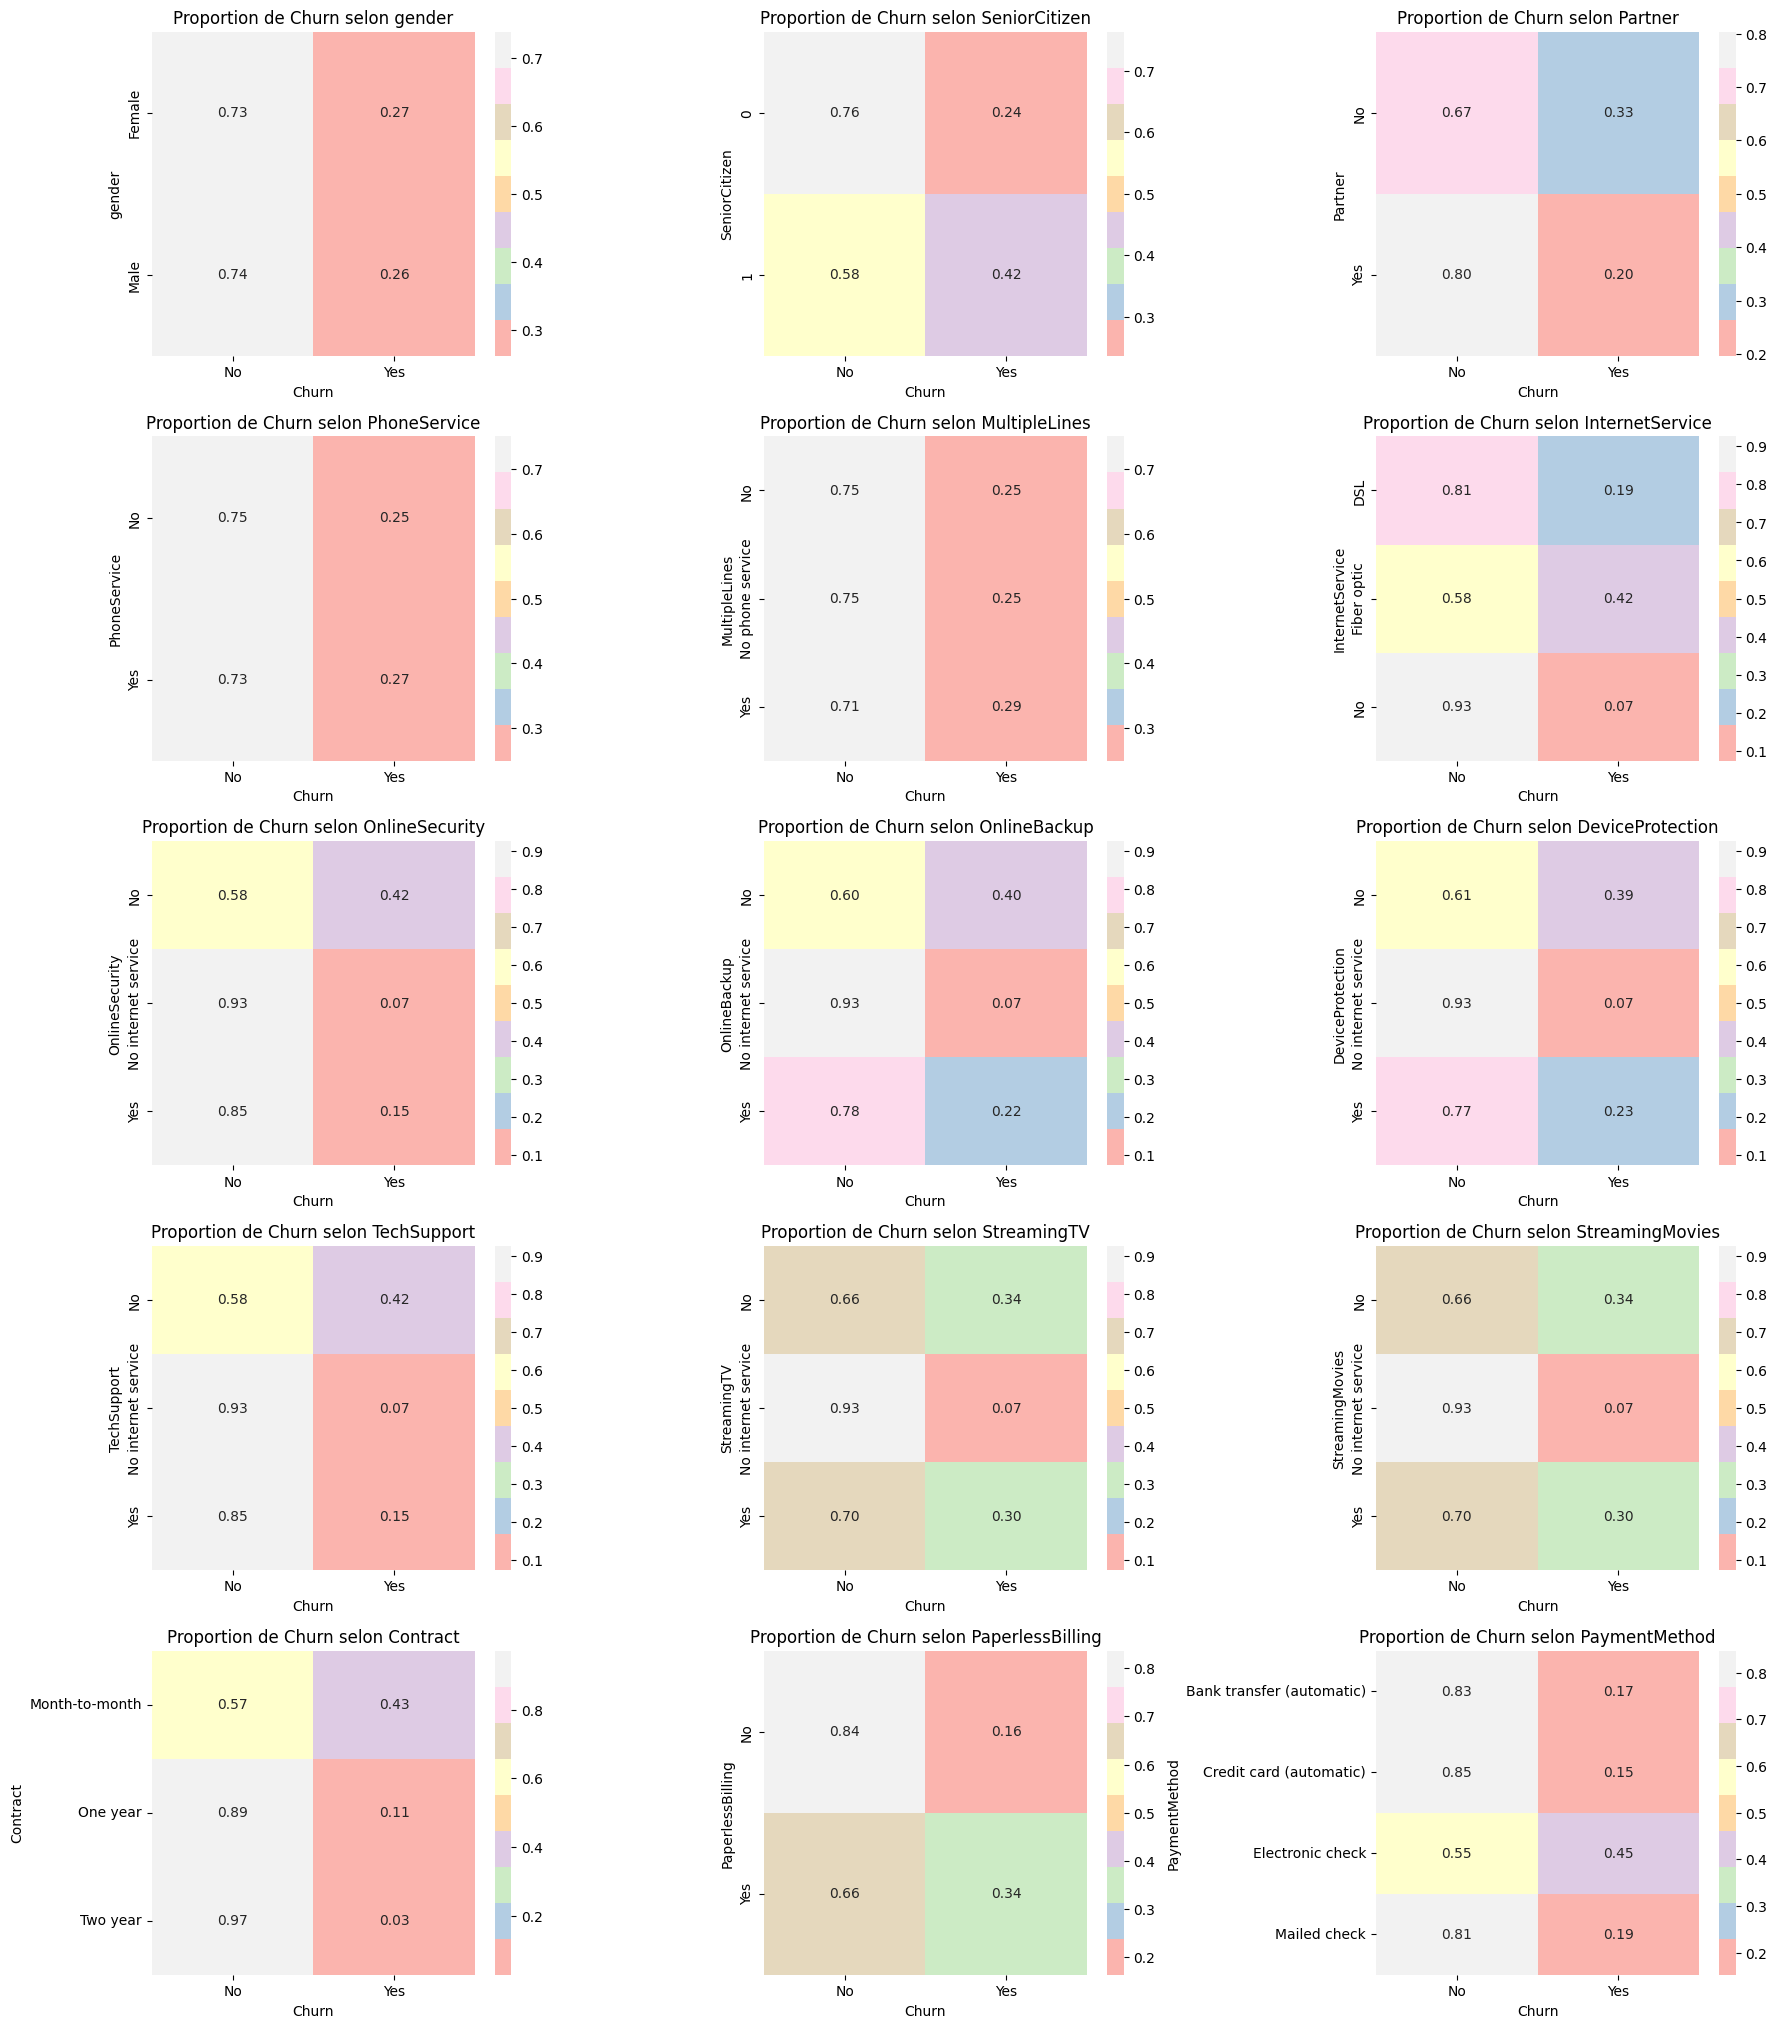

In [90]:
# Variable catégorielles vs cible
target = "Churn"
n_rows = 6
n_cols = math.ceil(len(data_cat) / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(data_cat):
    crosstab = pd.crosstab(data[col], data[target], normalize='index')
    sns.heatmap(crosstab, annot=True, cmap="Pastel1", fmt=".2f", ax=axes[i])
    axes[i].set_title(f"Proportion de {target} selon {col}")
    axes[i].set_ylabel(col)
    axes[i].set_xlabel(target)

# Supprimer les axes vides si le nombre de variables ne remplit pas la grille
for j in range(len(data_cat), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


* On remarque une tendance à la hausse des churns pour des personnes n'utilisant pas d'internet chez les variables: OnlineSecurity, OnlineBackup, DeviceProtection et TeckSupport.

* Par les variables "PaperlessBiling" et "PayemenMethod" on peut observer une augmentation du nombre de churn pour l'utilisation de moyen numérique.

* On peut également remarquer par la variable SeniorCitizen une augmentation du Churn des personnes agées.

Vérification de la corrélation des variables catégorielles avec "Churn" par le test de Khi-2

In [95]:
# Variables à tester
vars_to_test = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport","PaperlessBilling", "PaymentMethod", "SeniorCitizen"]

for var in vars_to_test:
    # Table de contingence
    crosstab = pd.crosstab(data[var], data["Churn"])
    
    # Test Khi-2
    chi2, p, dof, expected = chi2_contingency(crosstab)
    
    print(f"\nVariable: {var}")
    print("Chi2:", round(chi2, 3), "p-value:", round(p, 4))
    
    # Interprétation textuelle
    if p < 0.05:
        print(f"Il existe une dépendance significative entre {var} et Churn (p < 0.05).")
    else:
        print(f"Pas de dépendance significative entre {var} et Churn (p ≥ 0.05).")



Variable: OnlineSecurity
Chi2: 849.999 p-value: 0.0
Il existe une dépendance significative entre OnlineSecurity et Churn (p < 0.05).

Variable: OnlineBackup
Chi2: 601.813 p-value: 0.0
Il existe une dépendance significative entre OnlineBackup et Churn (p < 0.05).

Variable: DeviceProtection
Chi2: 558.419 p-value: 0.0
Il existe une dépendance significative entre DeviceProtection et Churn (p < 0.05).

Variable: TechSupport
Chi2: 828.197 p-value: 0.0
Il existe une dépendance significative entre TechSupport et Churn (p < 0.05).

Variable: PaperlessBilling
Chi2: 258.278 p-value: 0.0
Il existe une dépendance significative entre PaperlessBilling et Churn (p < 0.05).

Variable: PaymentMethod
Chi2: 648.142 p-value: 0.0
Il existe une dépendance significative entre PaymentMethod et Churn (p < 0.05).

Variable: SeniorCitizen
Chi2: 159.426 p-value: 0.0
Il existe une dépendance significative entre SeniorCitizen et Churn (p < 0.05).


Variables Continues et variable cible

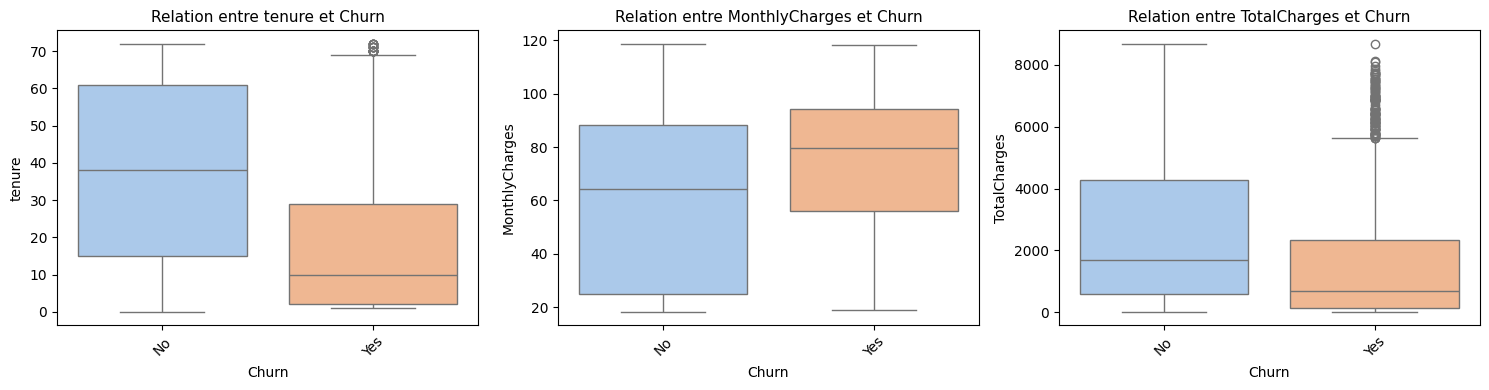

In [89]:
# Variables continues vs cible
n_rows = 1
n_cols = len(data_var_continues)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_cols == 1:
    axes = [axes]  # gérer le cas d'une seule variable
else:
    axes = axes.flatten()

for i, col in enumerate(data_var_continues):
    if data[target].dtype == "object" or pd.api.types.is_categorical_dtype(data[target]):
        # Numérique vs Catégorie → boxplot
        sns.boxplot(x=target, y=col, data=data, hue=target, palette="pastel", dodge=False, legend=False, ax=axes[i])
    else:
        # Numérique vs Numérique → scatterplot
        sns.scatterplot(x=col, y=target, data=data, ax=axes[i], alpha=0.6)

    axes[i].set_title(f"Relation entre {col} et {target}", fontsize=11)
    axes[i].tick_params(axis="x", rotation=45)

fig.tight_layout()
plt.show()


* Ici on observe carrément une tendance à la baisse des churns pour des personnes n'ayant des anciens clients par la variable "tenure".

Vérification de la corrélation d'une variable catégorielle avec "Churn" par le test de Student

In [98]:
# Séparation des groupes
group1 = data[data["Churn"]=="Yes"]["tenure"]
group2 = data[data["Churn"]=="No"]["tenure"]

# Test t de Student
stat, p = ttest_ind(group1, group2)

print("t-stat:", round(stat, 3), "p-value:", round(p, 4))

# Interprétation automatique
if p < 0.05:
    print("La différence des moyennes d'Age entre Churn=Yes et Churn=No est significative (p < 0.05).")
else:
    print("Pas de différence significative des moyennes d'Age entre Churn=Yes et Churn=No (p ≥ 0.05).")


t-stat: -31.58 p-value: 0.0
La différence des moyennes d'Age entre Churn=Yes et Churn=No est significative (p < 0.05).


## MACHINE LEARNING